We need to predict the summary column by designing a model of neural networks

### Importing necessary libraries

In [163]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns             
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow import keras
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Loading the dataset 

In [164]:
#import dataset from data.csv file
dataset = pd.read_csv('/kaggle/input/weather-dataset/weatherHistory.csv')
print(dataset.info())
# print(dataset.dtypes)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB
None


### Exploratory data analysis

Perform exploratory data analysis to get insights about the data and handle any missing values or outliers

1. Remove duplicate rows
2. Check for NULL values in dataset.

**Note** :- Post observation we find null values in precipitation type. A null value in the 'Precip Type' column could mean that the data for that particular time period is missing or was not recorded. It is not safe to assume that a null value means it did not rain or snow.

In [165]:
# print the row count before removing duplicates
print("Row count before removing duplicates:", len(dataset))

# drop duplicates
dataset.drop_duplicates(inplace=True)

# print the row count after removing duplicates
print("Row count after removing duplicates:", len(dataset))

# check for missing values
print(dataset.isnull().sum())


Row count before removing duplicates: 96453
Row count after removing duplicates: 96429
Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64


### Data cleaning 

1. Remove all null values from data set since 517/96429 = 0.0053 << 1

2. Drop Loud Cover as it only contains value 0 (no use in training)

In [166]:
dataset = dataset.dropna()
print(dataset.isnull().sum())


Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
Daily Summary               0
dtype: int64


In [167]:
# Drop the "Loud Cover" column
dataset = dataset.drop('Loud Cover', axis=1)
dataset.info()
dataset.columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95912 entries, 0 to 96452
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            95912 non-null  object 
 1   Summary                   95912 non-null  object 
 2   Precip Type               95912 non-null  object 
 3   Temperature (C)           95912 non-null  float64
 4   Apparent Temperature (C)  95912 non-null  float64
 5   Humidity                  95912 non-null  float64
 6   Wind Speed (km/h)         95912 non-null  float64
 7   Wind Bearing (degrees)    95912 non-null  float64
 8   Visibility (km)           95912 non-null  float64
 9   Pressure (millibars)      95912 non-null  float64
 10  Daily Summary             95912 non-null  object 
dtypes: float64(7), object(4)
memory usage: 8.8+ MB


Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)',
       'Daily Summary'],
      dtype='object')

### Check for Outliers (Abnormal values) 

an outlier is an observation that lies an abnormal distance from other values in a random sample from a population. Outliers can indicate either measurement or recording errors, or that the data is drawn from a different distribution than the rest of the data. Outliers can skew the results of statistical analyses, affecting the mean, median, and standard deviation of the data. Therefore, it is important to detect and handle outliers appropriately before performing any statistical analysis on the data.

This code loads the weather dataset, checks for outliers using box plots and histograms, and removes outliers by setting threshold values for each variable. Finally, it re-checks for outliers using box plots and histograms to ensure that the outliers have been removed.

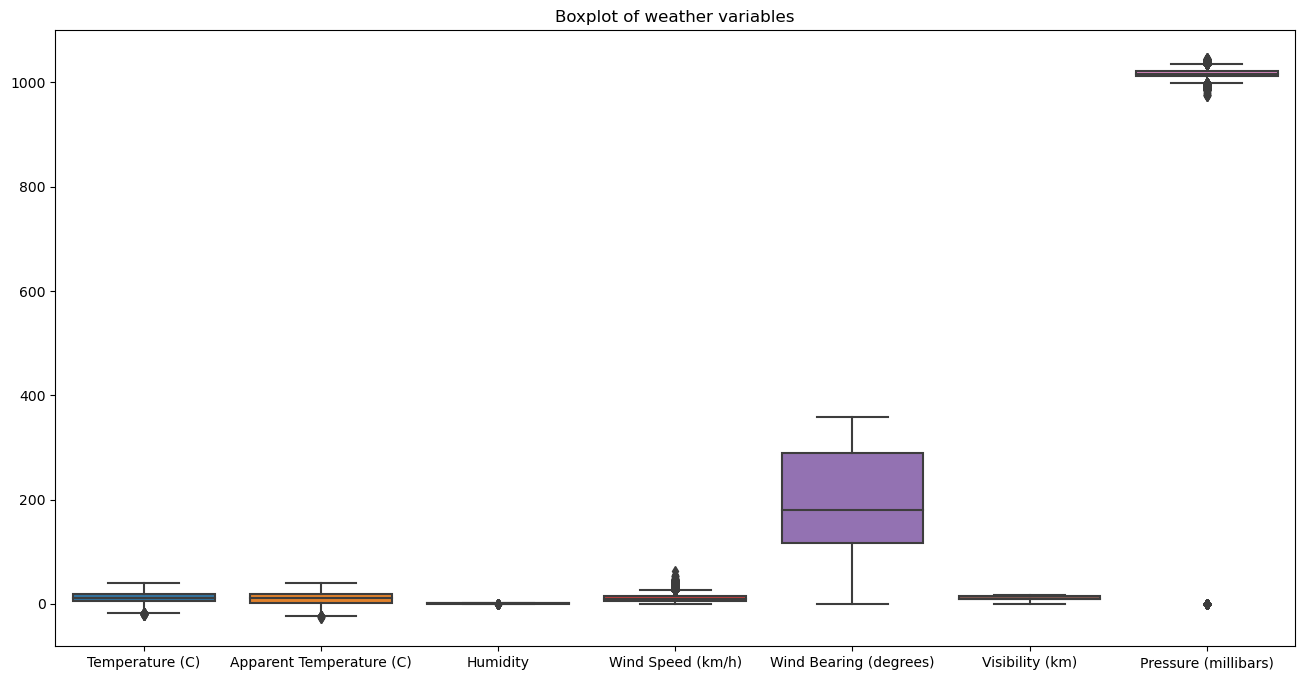

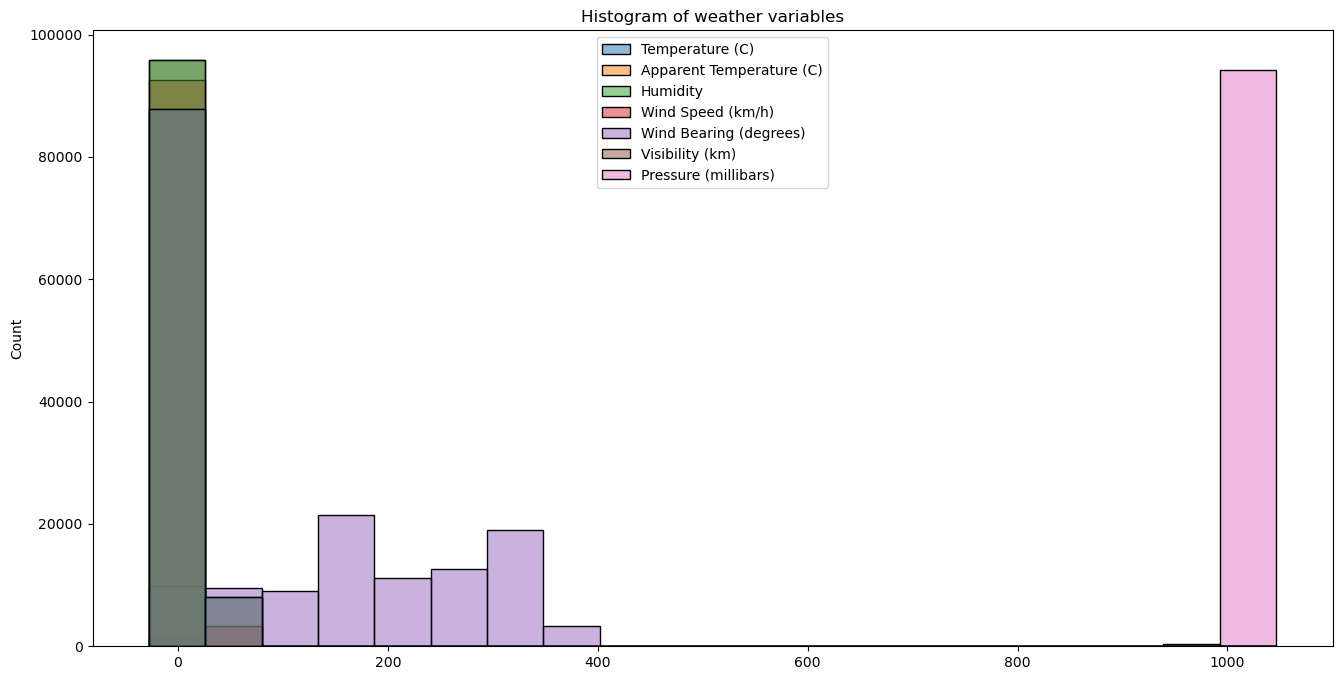

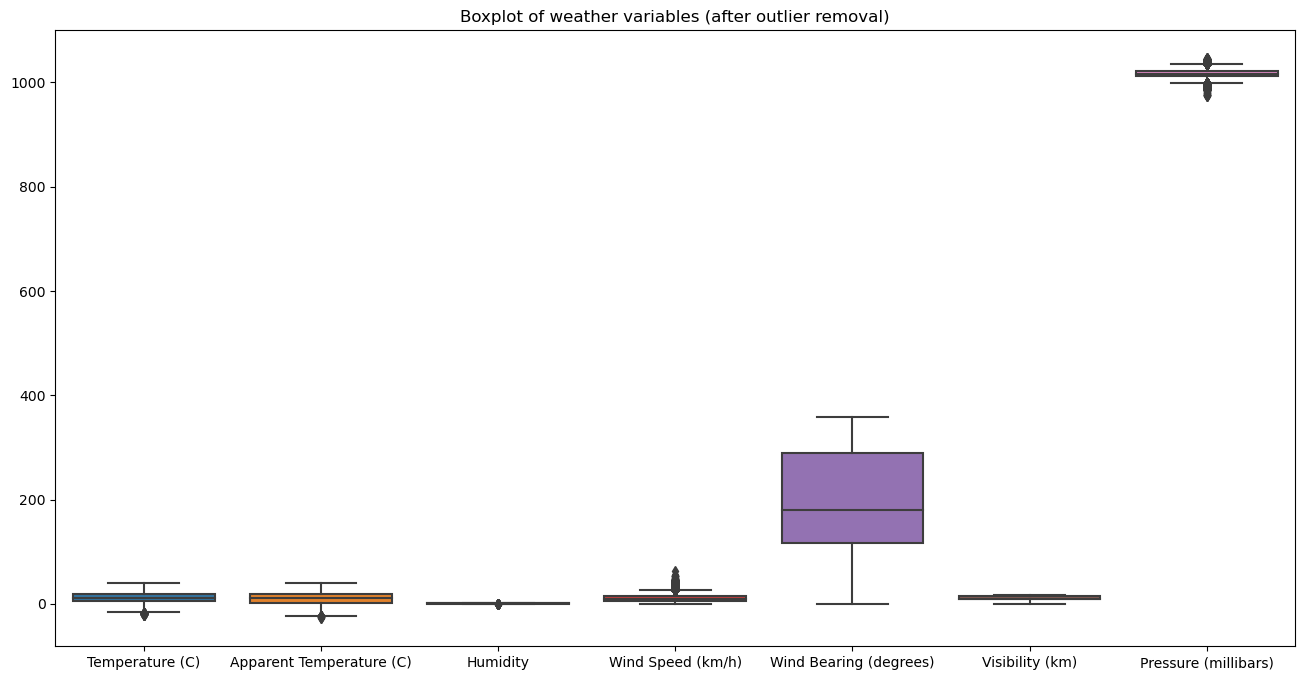

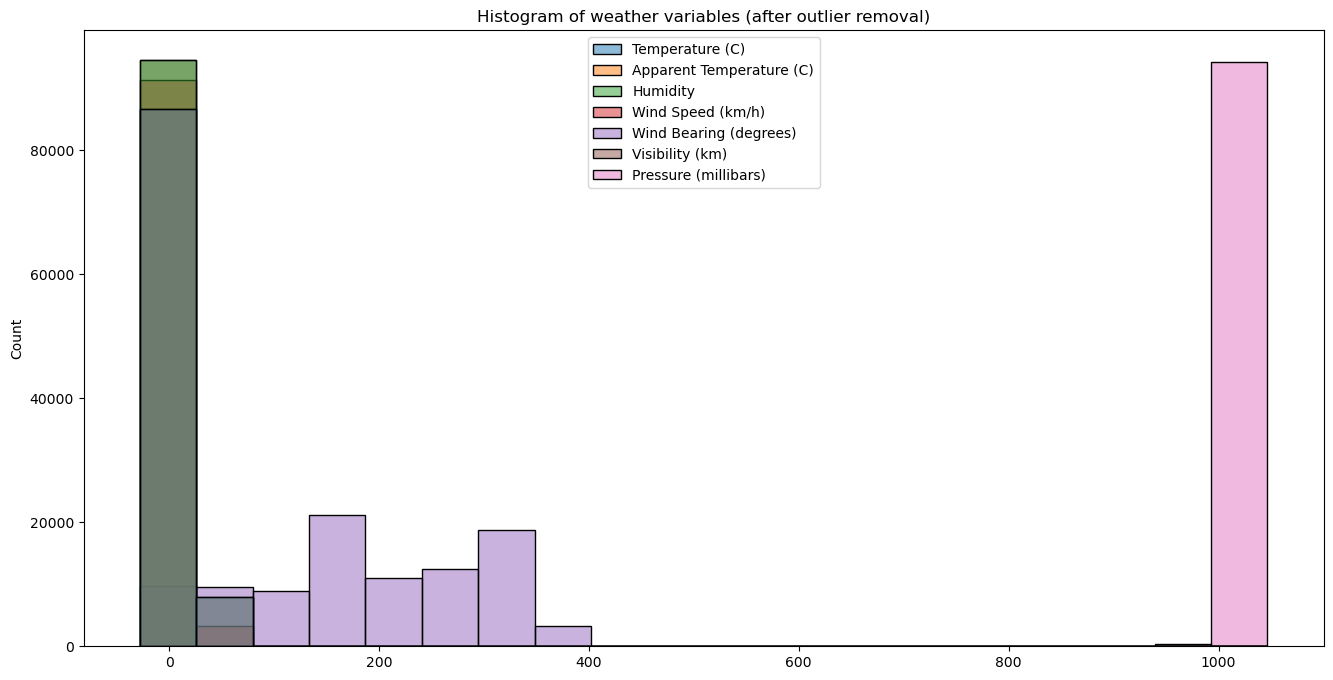

Length of dataset post  outplier removal :  94624


,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
count,94624.000000,94624.000000,94624.000000,94624.000000,94624.000000,94624.000000,94624.000000
mean,11.954747,10.882686,0.734909,10.780227,187.425273,10.397271,1016.801563
std,9.564560,10.706324,0.195838,6.899016,107.400837,4.168015,7.770814
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,973.780000
25%,4.655556,2.300000,0.600000,5.796000,116.000000,8.420300,1012.110000
50%,12.055556,12.055556,0.780000,9.909550,180.000000,10.046400,1016.530000
75%,18.851389,18.851389,0.890000,14.103600,290.000000,14.908600,1021.130000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,1046.380000


In [168]:
# Check for outliers using box plots(only with float type values)
plt.figure(figsize=(16,8))
sns.boxplot(data=dataset[['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']])
plt.title("Boxplot of weather variables")
plt.show()

# Check for outliers using histograms
plt.figure(figsize=(16,8))
sns.histplot(data=dataset[['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']], bins=20)
plt.title("Histogram of weather variables")
plt.show()

# Handle outliers by removing values beyond certain thresholds
dataset = dataset[dataset['Temperature (C)'] < 50]
dataset = dataset[dataset['Humidity'] <= 1]
dataset = dataset[dataset['Wind Speed (km/h)'] < 100]
dataset = dataset[dataset['Wind Bearing (degrees)'] <= 360]
dataset = dataset[dataset['Visibility (km)'] < 50]
dataset = dataset[dataset['Pressure (millibars)'] > 500]
dataset = dataset[dataset['Pressure (millibars)'] < 1100]

# Check for outliers again using box plots
plt.figure(figsize=(16,8))
sns.boxplot(data=dataset[['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']])
plt.title("Boxplot of weather variables (after outlier removal)")
plt.show()

# Check for outliers again using histograms
plt.figure(figsize=(16,8))
sns.histplot(data=dataset[['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']], bins=20)
plt.title("Histogram of weather variables (after outlier removal)")
plt.show()

print("Length of dataset post  outplier removal : ",len(dataset))

dataset.describe()

###  One Hot encode column 'Precip type'   

Label encoding assigns a numerical label to each category in a feature. For example, if there are three categories in a feature, they might be encoded as 0, 1, and 2. One drawback of label encoding is that it may imply an ordinal relationship between the categories when there is none. For example, if we encode "red" as 0, "blue" as 1, and "green" as 2, the model may interpret "green" as being closer to "blue" than to "red," which may not be desirable.

One-hot encoding creates a new binary column for each category in a feature, and assigns a value of 1 for the corresponding category and 0 for all other categories. This avoids the issue of ordinality, but can lead to a large increase in the number of features in the dataset.

**Note the two columns being created at last post one hot encoding of dataset column 'Precip type' in weather_data varible.**

In [169]:
# One-hot encode categorical variables
dataset = pd.get_dummies(dataset, columns=['Precip Type'])

dataset.info()
dataset.describe()
dataset.columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94624 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            94624 non-null  object 
 1   Summary                   94624 non-null  object 
 2   Temperature (C)           94624 non-null  float64
 3   Apparent Temperature (C)  94624 non-null  float64
 4   Humidity                  94624 non-null  float64
 5   Wind Speed (km/h)         94624 non-null  float64
 6   Wind Bearing (degrees)    94624 non-null  float64
 7   Visibility (km)           94624 non-null  float64
 8   Pressure (millibars)      94624 non-null  float64
 9   Daily Summary             94624 non-null  object 
 10  Precip Type_rain          94624 non-null  uint8  
 11  Precip Type_snow          94624 non-null  uint8  
dtypes: float64(7), object(3), uint8(2)
memory usage: 8.1+ MB


Index(['Formatted Date', 'Summary', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)',
       'Daily Summary', 'Precip Type_rain', 'Precip Type_snow'],
      dtype='object')

In [170]:
print("No. of columns till now : ", dataset.shape[1])

No. of columns till now :  12


### Convert the 'Formatted Date' column to a datetime format and set it as the index of the dataset

In [171]:
dataset['Formatted Date'] = pd.to_datetime(dataset['Formatted Date'], utc=True)
dataset.set_index('Formatted Date', inplace=True)



### One-hot encode the categorical variables 'Daily Summary'

total 224 columns generated.(Summary needs to be predicted)

In [172]:

daily_summary_onehot = pd.get_dummies(dataset['Daily Summary'], prefix='Daily_Summary')

dataset = pd.concat([dataset, daily_summary_onehot], axis=1)
dataset.drop(['Daily Summary'], axis=1, inplace=True) # remove the columns

dataset.columns

Index(['Summary', 'Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
       'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
       'Pressure (millibars)', 'Precip Type_rain', 'Precip Type_snow',
       ...
       'Daily_Summary_Partly cloudy until evening.',
       'Daily_Summary_Partly cloudy until morning.',
       'Daily_Summary_Partly cloudy until night and breezy in the afternoon.',
       'Daily_Summary_Partly cloudy until night and breezy in the morning.',
       'Daily_Summary_Partly cloudy until night and breezy starting in the morning continuing until afternoon.',
       'Daily_Summary_Partly cloudy until night.',
       'Daily_Summary_Rain throughout the day.',
       'Daily_Summary_Rain until afternoon.',
       'Daily_Summary_Rain until morning.',
       'Daily_Summary_Windy in the afternoon.'],
      dtype='object', length=224)

### Drop Summary column and One hot encode it since it will be the dependent variable

we store it in a seperate variable for use later

In [173]:
# Drop the 'Summary' column and store it in a separate variable
summary = dataset['Summary']
dataset = dataset.drop(['Summary'], axis=1)

# One-hot encode the 'summary' variable
summary_onehot = pd.get_dummies(summary, prefix='Summary')

print("No. of columns till now in dataset : ", dataset.shape[1])
print("No. of columns till now in summary : ", summary_onehot.shape[1])


summary_onehot


No. of columns till now in dataset :  223
No. of columns till now in summary :  27


,Summary_Breezy,Summary_Breezy and Dry,Summary_Breezy and Foggy,Summary_Breezy and Mostly Cloudy,Summary_Breezy and Overcast,Summary_Breezy and Partly Cloudy,Summary_Clear,Summary_Dangerously Windy and Partly Cloudy,Summary_Drizzle,Summary_Dry,...,Summary_Mostly Cloudy,Summary_Overcast,Summary_Partly Cloudy,Summary_Rain,Summary_Windy,Summary_Windy and Dry,Summary_Windy and Foggy,Summary_Windy and Mostly Cloudy,Summary_Windy and Overcast,Summary_Windy and Partly Cloudy
Formatted Date,,,,,,,,,,,,,,,,,,,,,
2006-03-31 22:00:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2006-03-31 23:00:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2006-04-01 00:00:00+00:00,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2006-04-01 01:00:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2006-04-01 02:00:00+00:00,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-09 17:00:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2016-09-09 18:00:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2016-09-09 19:00:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


### Normalize the numerical variables

Normalizing the numerical variables means scaling them to have a mean of zero and a standard deviation of one, so that they are on a similar scale and have equal impact on the neural network model. This is important because neural networks often use gradient-based optimization algorithms that can be sensitive to differences in scale between the input variables. Normalization also helps to prevent large inputs from dominating the learning process and improving the convergence of the optimization algorithm.

In [174]:
scaler = MinMaxScaler()
dataset_scaled = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns, index=dataset.index)
summary_onehot_scaled = pd.DataFrame(scaler.fit_transform(summary_onehot), columns=summary_onehot.columns, index=summary_onehot.index)

### Split the dataset into training and testing sets

80-20 split assumed

It depends on the specific use case and what question or problem we are trying to address with the model. It is important to carefully consider the goals of the analysis and select the most appropriate dependent variable based on those goals.

In the case of training a model to predict summary, you can certainly one-hot encode the summary column and use it as a dependent variable in your neural network. However, it would require a modification in your model architecture as you would need to have multiple output nodes, one for each category in the one-hot encoded summary column. You would also need to change the loss function to categorical cross-entropy, which is typically used for multi-class classification problems.

dependent variable -  Summary(one hot encoded)

#### **Note :-**
If you have already separated your dependent variable 'summary_onehot_scaled' and independent variable 'dataset_scaled' and have them stored in separate variables, then there is no need to concatenate them. You can simply use them as X and y in your model training.

In [175]:
X = dataset_scaled
y = summary_onehot_scaled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Define and train the neural network

In designing a neural network, all data needs to be in numerical format, so some form of encoding is necessary for categorical variables. One-hot encoding is often preferred over label encoding because it avoids the issue of ordinality, and can help the model better capture non-linear relationships between categorical variables and the target variable.

In [176]:

# Determine the number of features
n_features = X_train.shape[1]

# Define the model
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(n_features,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(27, activation='softmax')
])

# Compile the model
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50
1893/1893 [==============================] - 7s 3ms/step - loss: 1.0413 - accuracy: 0.5740 - val_loss: 0.9112 - val_accuracy: 0.6152
Epoch 2/50
1893/1893 [==============================] - 6s 3ms/step - loss: 0.9128 - accuracy: 0.6095 - val_loss: 0.8996 - val_accuracy: 0.6205
Epoch 3/50
1893/1893 [==============================] - 7s 3ms/step - loss: 0.8887 - accuracy: 0.6180 - val_loss: 0.8741 - val_accuracy: 0.6245
Epoch 4/50
1893/1893 [==============================] - 7s 4ms/step - loss: 0.8722 - accuracy: 0.6243 - val_loss: 0.8695 - val_accuracy: 0.6306
Epoch 5/50
1893/1893 [==============================] - 7s 4ms/step - loss: 0.8620 - accuracy: 0.6278 - val_loss: 0.8727 - val_accuracy: 0.6248
Epoch 6/50
1893/1893 [==============================] - 7s 4ms/step - loss: 0.8535 - accuracy: 0.6311 - val_loss: 0.8633 - val_accuracy: 0.6310
Epoch 7/50
1893/1893 [==============================] - 6s 3ms/step - loss: 0.8458 - accuracy: 0.6342 - val_loss: 0.8567 - val_accuracy:

### Evaluate the model's performance

In [177]:
loss_list = model.evaluate(X_test, y_test)
test_loss = loss_list[0]
print('Test Loss: {:.2f}'.format(test_loss))


592/592 [==============================] - 1s 2ms/step - loss: 0.8448 - accuracy: 0.6331
Test Loss: 0.84


In [178]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(np.array(y_test), axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='macro', zero_division=1)
recall = recall_score(y_test_classes, y_pred_classes, average='macro', zero_division=1)
f1 = f1_score(y_test_classes, y_pred_classes, average='macro', zero_division=1)

print('Test Accuracy: {:.2f}'.format(accuracy))
print('Test Precision: {:.2f}'.format(precision))
print('Test Recall: {:.2f}'.format(recall))
print('Test F1-score: {:.2f}'.format(f1))


592/592 [==============================] - 1s 1ms/step
Test Accuracy: 0.63
Test Precision: 0.72
Test Recall: 0.34
Test F1-score: 0.34


### Viewing plots for some insight knowledge about model

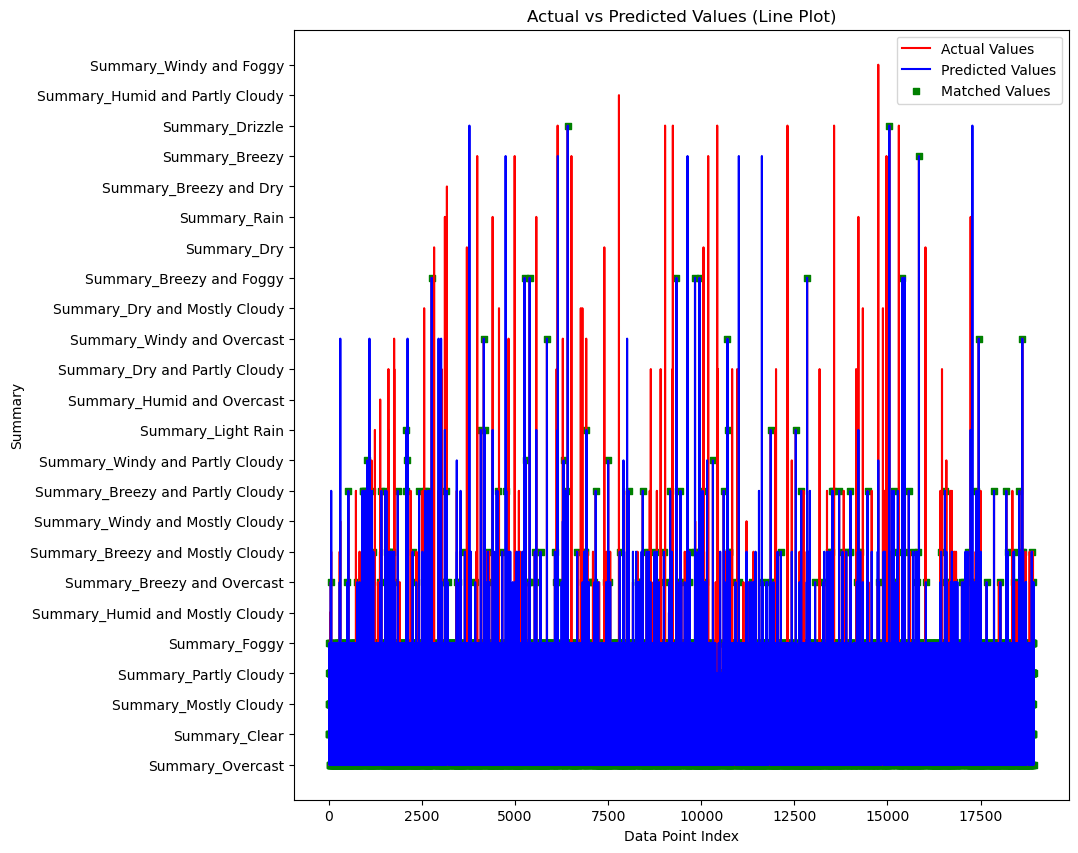

In [179]:
y_pred_df = pd.DataFrame(y_pred, columns=y_test.columns)
y_pred_df = y_pred_df.reset_index(drop=True)
plt.figure(figsize=(10, 10))

y_test = y_test.reset_index(drop=True)

# Create arrays to store x and y values for actual and predicted values
x_actual = []
y_actual = []
x_predicted = []
y_predicted = []

# Loop through each row of y_test
for i, row in y_test.iterrows():
    # Find the index of the column with value 1 in y_test
    col_idx_test = row.idxmax()
    # Find the index of the column with highest predicted probability in y_pred
    col_idx_pred = y_pred_df.iloc[i].idxmax()
    # Store x and y values for actual and predicted values
    x_actual.append(i)
    y_actual.append(col_idx_test)
    x_predicted.append(i)
    y_predicted.append(col_idx_pred)

# Create line plot for actual values with red color
plt.plot(x_actual, y_actual, c='r', label='Actual Values')
# Create line plot for predicted values with blue color
plt.plot(x_predicted, y_predicted, c='b', label='Predicted Values')
# Create scatter plot for matched values with green color
for i in range(len(y_actual)):
    if y_actual[i] == y_predicted[i]:
        plt.scatter(x_actual[i], y_actual[i], c='g', label='Matched Values', s=20, marker='s')

# Add a legend with the three labels in the desired order
plt.legend(labels=['Actual Values', 'Predicted Values', 'Matched Values'])
plt.xlabel('Data Point Index')
plt.ylabel('Summary')
plt.title('Actual vs Predicted Values (Line Plot)')

plt.show()


Text(0.5, 1.0, 'Actual vs Predicted Values')

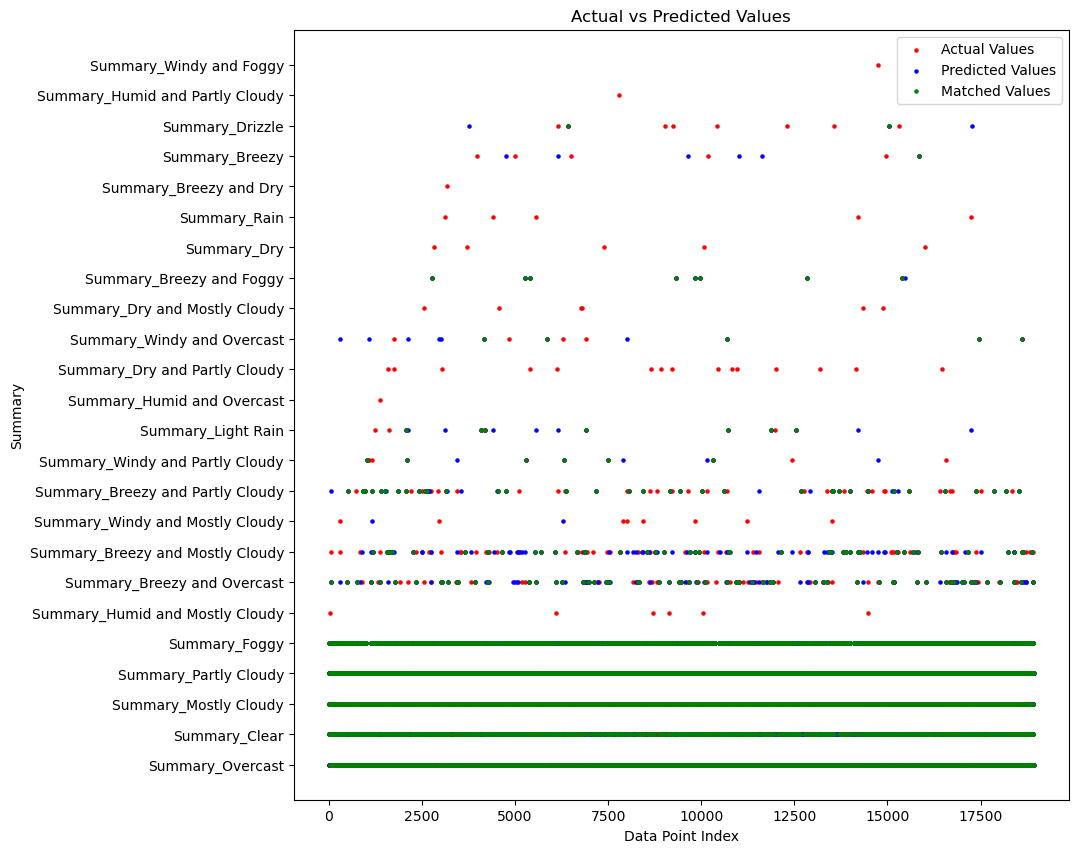

In [180]:
y_pred_df = pd.DataFrame(y_pred, columns=y_test.columns)
y_pred_df = y_pred_df.reset_index(drop=True)
plt.figure(figsize=(10, 10))

y_test = y_test.reset_index(drop=True)

# Create arrays to store x and y values for actual and predicted values
x_actual = []
y_actual = []
x_predicted = []
y_predicted = []

# Loop through each row of y_test
for i, row in y_test.iterrows():
    # Find the index of the column with value 1 in y_test
    col_idx_test = row.idxmax()
    # Find the index of the column with highest predicted probability in y_pred
    col_idx_pred = y_pred_df.iloc[i].idxmax()
    # Store x and y values for actual and predicted values
    x_actual.append(i)
    y_actual.append(col_idx_test)
    x_predicted.append(i)
    y_predicted.append(col_idx_pred)

# Create scatter plot for actual values with red dots
plt.scatter(x_actual, y_actual, c='r', label='Actual Values', s=5)
# Create scatter plot for predicted values with blue dots
plt.scatter(x_predicted, y_predicted, c='b', label='Predicted Values', s=5)
# Create scatter plot for matched values with green dots
for i in range(len(y_actual)):
    if y_actual[i] == y_predicted[i]:
        plt.scatter(x_actual[i], y_actual[i], c='g', label='Matched Values', s=5)

# Add a legend with the three labels in the desired order
plt.legend(labels=['Actual Values', 'Predicted Values', 'Matched Values'])
plt.xlabel('Data Point Index')
plt.ylabel('Summary')
plt.title('Actual vs Predicted Values')
